<a href="https://colab.research.google.com/github/chanmol1999/LamenessDetection/blob/main/dryad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
!pip install skrebate
import numpy as np
from skrebate import ReliefF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

  Created wheel for skrebate: filename=skrebate-0.62-cp37-none-any.whl size=29256 sha256=c44122ee4903eaeae5ff7cb5a5f557e8d2b66cc4d98f3f7b37e98b0ab05a9532
  Stored in directory: /root/.cache/pip/wheels/6b/0e/2f/540392932d3a01060f04c242d3b9bee80dfd87f63d80b3a9a0
Successfully built skrebate


In [2]:
#%% scoring functions
def tn(y_true, y_pred):    
  return confusion_matrix(y_true, y_pred)[0, 0]

In [3]:
def fp(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)[0, 1]

In [4]:
def fn(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)[1, 0]

In [5]:
def tp(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)[1, 1]

In [6]:
#%% read in & pre-process featureset
# specify file path & read file
featureset2018_p = 'dataset.csv'
fs2018 = pd.read_csv(featureset2018_p)

# generate binary Lameness column
fs2018.loc[fs2018.LMS < 2, 'Lameness'] = 0
fs2018.loc[fs2018.LMS > 1, 'Lameness'] = 1
print(fs2018)

       Unnamed: 0  LMS  ...  SpectralArea_GyrMag_diff  Lameness
0               1    3  ...               2921935.083       1.0
1               2    3  ...               4154000.541       1.0
2               3    3  ...               5093477.749       1.0
3               4    3  ...               2192810.351       1.0
4               5    3  ...               2290385.773       1.0
...           ...  ...  ...                       ...       ...
20099       20100    0  ...               5052865.902       0.0
20100       20101    0  ...               4262954.212       0.0
20101       20102    0  ...               3226348.909       0.0
20102       20103    0  ...               3107034.891       0.0
20103       20104    0  ...               4635145.117       0.0

[20104 rows x 393 columns]


In [7]:
#%% Define Label & Select relevant columns: AccMag_g_dff & GyrMag_diff
# initialise column list
diff_feature_columns = ['SheepID', 'RecordID', 'Day', 'WalkingStandingLying', 'Lameness']
# only use columns that are based on AccMag_G and GyrMag Diff columns
for col in fs2018.columns:    
  if (('AccMag_g' in col) or ('GyrMag' in col)) & ('diff' in col):        
    diff_feature_columns.append(col)

In [8]:
# filter featureset
RelevantSubset = fs2018[diff_feature_columns]
#%% variables for classificaiton
# diverse range of models
models = [RandomForestClassifier(n_estimators=250, class_weight="balanced"),
          SVC(), MLPClassifier(), KNeighborsClassifier(5),
          AdaBoostClassifier(n_estimators=100)]
models = [KNeighborsClassifier(5)]
names = ['RF', 'SVM', 'MLP', 'KNC', 'AdaBoost']
names = ['KNC']
# measures to extract
measures = ['accuracy', 'precision', 'recall', 'f1', 'specificity']
# stratified 10-fold cross-validation
skf = StratifiedKFold(10, shuffle=True)
# specify scoring functions to use
scoring = {'accuracy': make_scorer(accuracy_score),'precision': make_scorer(precision_score),'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),'tp' : make_scorer(tp),'tn' : make_scorer(tn),'fp' : make_scorer(fp),'fn' : make_scorer(fn)}


In [9]:
# %% initialise result DF
# result df column names
colnames = ['WSL', 'Features']
for col in [f'{i}_{measure}' for i in names for measure in measures]:    
  colnames.append(col)
#%% Classifier Pipeline -  ReleiefF
# initialise result df
Train = pd.DataFrame(columns=colnames)
Test = pd.DataFrame(columns=colnames)
print(Train)
print(Test)

Empty DataFrame
Columns: [WSL, Features, KNC_accuracy, KNC_precision, KNC_recall, KNC_f1, KNC_specificity]
Index: []
Empty DataFrame
Columns: [WSL, Features, KNC_accuracy, KNC_precision, KNC_recall, KNC_f1, KNC_specificity]
Index: []


In [10]:
# iterate over activities
for wsl in ['Walking','Standing','Lying']:
  print(wsl)     
# filter featureset for relevant behaviour   
# print(wsl) 
  RSwsl = RelevantSubset[RelevantSubset.WalkingStandingLying == wsl].copy()    
  Xwsl = RSwsl.drop(['SheepID', 'RecordID', 'Day', 'WalkingStandingLying', 'Lameness'],axis=1).copy()
  y = RelevantSubset[RelevantSubset.WalkingStandingLying == wsl].Lameness.copy()
#  Feature Ranking   
  print(RSwsl) 
  print('apply ReliefF') 
  print(y)   
  RelF = ReliefF()
# labels = np.unique(y); 
# print(labels)    
  RelF.fit(Xwsl.values, y.values)    
  Feature_Ranking = Xwsl.columns[RelF.top_features_]
  print(Feature_Ranking)
  for nf in range(1,33):
    print(f'{nf} feature(s)')
    print(Feature_Ranking[:nf])        
    X = Xwsl[Feature_Ranking[:nf]]        
    # model building        
    training = [wsl, nf]        
    testing = [wsl, nf]        
    for est, name in zip(models, names):            
      print(name)           
      cv_res = cross_validate(est, X, y, cv=skf,                                    
                              scoring=scoring, return_train_score=True)            
      RSwsl[f'{name}_predictions_{nf}'] = cross_val_predict(est, X, y, cv=skf)            
      # store cv results in result vector            
      print('append results')            
      for measure in measures:        
        if measure == 'specificity':                    
          continue                
        training.append(cv_res[f'train_{measure}'].mean())                
        testing.append(cv_res[f'test_{measure}'].mean())            
      training.append((cv_res['train_tn'] / (cv_res['train_tn'] + cv_res['train_fp'])).mean())            
      testing.append((cv_res['test_tn'] / (cv_res['test_tn'] + cv_res['test_fp'])).mean())   
    print('training',training)
    print('testing',testing)     
    Train.loc[len(Train)] = training
    Test.loc[len(Test)] = testing        
    print()   
  RSwsl.to_csv(wsl+'rswl.csv', index=False)    
  print()
Train.to_csv('train.csv', index=False)
Test.to_csv('test.csv', index=False)
print(cv_res)

Walking
       SheepID  ...  SpectralArea_GyrMag_diff
13           1  ...               1983500.138
176          1  ...               2788243.035
177          1  ...               3532192.479
178          1  ...               5346025.202
181          1  ...               6334391.821
...        ...  ...                       ...
20099        9  ...               5052865.902
20100        9  ...               4262954.212
20101        9  ...               3226348.909
20102        9  ...               3107034.891
20103        9  ...               4635145.117

[6344 rows x 37 columns]
apply ReliefF
13       1.0
176      1.0
177      1.0
178      1.0
181      1.0
        ... 
20099    0.0
20100    0.0
20101    0.0
20102    0.0
20103    0.0
Name: Lameness, Length: 6344, dtype: float64
Index(['SpectralEntropy_AccMag_g_diff', 'ZeroCrossing_AccMag_g_diff',
       'DominantFrequency_AccMag_g_diff', 'DominantFrequency_GyrMag_diff',
       'HarmonicFreq2_AccMag_g_diff', 'SpectralEntropy_GyrMag_diff'

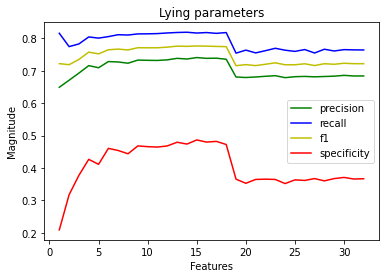

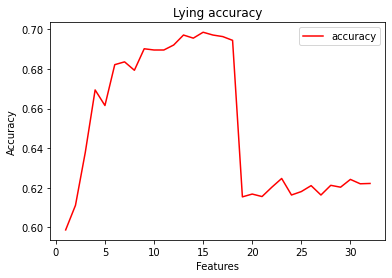

In [11]:
knc_test = pd.read_csv('test.csv')
lying_test = knc_test[knc_test['WSL'].values == 'Lying']
walk_test = knc_test[knc_test['WSL'].values == 'Walking']
stand_test = knc_test[knc_test['WSL'].values == 'Standing']
## lying_graph
features = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])
accuracy = np.array(lying_test['KNC_accuracy'])
precision = np.array(lying_test['KNC_precision'])
recall = np.array(lying_test['KNC_recall'])
f1 = np.array(lying_test['KNC_f1'])
specificity = np.array(lying_test['KNC_specificity'])
plt.plot(features, precision, color='g', label='precision')
plt.plot(features, recall, color='b', label='recall')
plt.plot(features, f1, color='y', label='f1')
plt.plot(features, specificity, color='r', label='specificity')
plt.xlabel("Features")
plt.ylabel("Magnitude")
plt.title("Lying parameters")
plt.legend()
plt.show()
plt.plot(features, accuracy, color='r', label='accuracy')
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.title("Lying accuracy")
plt.legend()
plt.show()


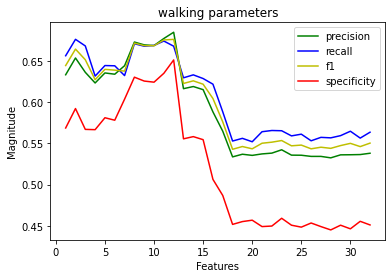

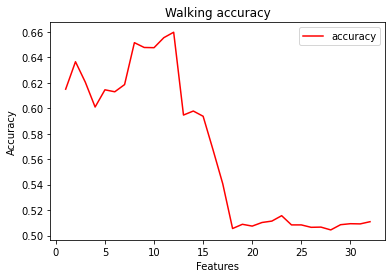

In [12]:
## walking_graph
features = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])
accuracy = np.array(walk_test['KNC_accuracy'])
precision = np.array(walk_test['KNC_precision'])
recall = np.array(walk_test['KNC_recall'])
f1 = np.array(walk_test['KNC_f1'])
specificity = np.array(walk_test['KNC_specificity'])
plt.plot(features, precision, color='g', label='precision')
plt.plot(features, recall, color='b', label='recall')
plt.plot(features, f1, color='y', label='f1')
plt.plot(features, specificity, color='r', label='specificity')
plt.xlabel("Features")
plt.ylabel("Magnitude")
plt.title("walking parameters")
plt.legend()
plt.show()
plt.plot(features, accuracy, color='r', label='accuracy')
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.title("Walking accuracy")
plt.legend()
plt.show()


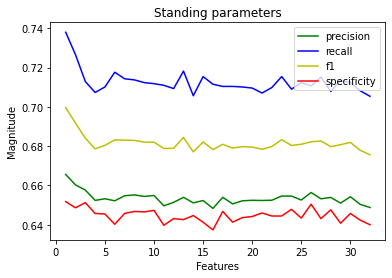

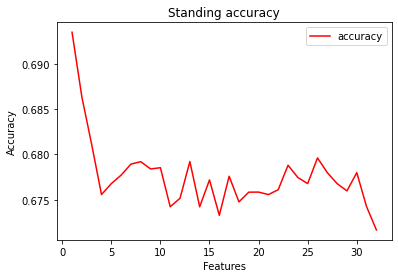

In [13]:
## standing_graph
features = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])
accuracy = np.array(stand_test['KNC_accuracy'])
precision = np.array(stand_test['KNC_precision'])
recall = np.array(stand_test['KNC_recall'])
f1 = np.array(stand_test['KNC_f1'])
specificity = np.array(stand_test['KNC_specificity'])
plt.plot(features, precision, color='g', label='precision')
plt.plot(features, recall, color='b', label='recall')
plt.plot(features, f1, color='y', label='f1')
plt.plot(features, specificity, color='r', label='specificity')
plt.xlabel("Features")
plt.ylabel("Magnitude")
plt.title("Standing parameters")
plt.legend()
plt.show()
plt.plot(features, accuracy, color='r', label='accuracy')
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.title("Standing accuracy")
plt.legend()
plt.show()
